# Introduction

In this notebook, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.


Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [ ]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms

transform_train = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32,padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])
transform_test = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])
batch_size=128
# Create training set and define training dataloader

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=4)
# Create test set and define test dataloader

testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=4)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [11]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

shape of images: torch.Size([3, 32, 32])
length of trainset: 50000
length of testset: 10000
cat


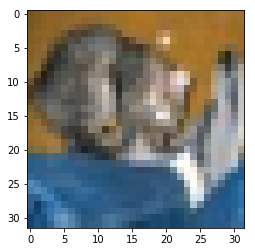

ship


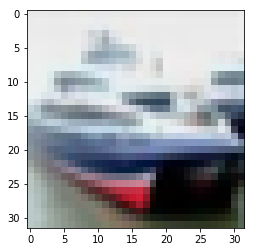

ship


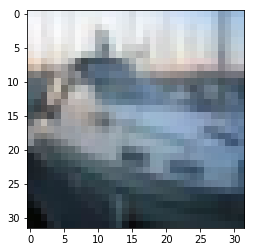

plane


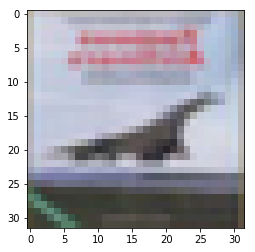

frog


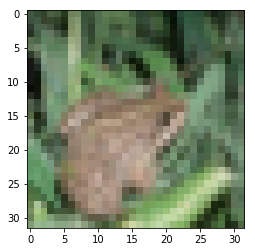

In [19]:
# Explore data
dataiter = iter(trainloader)
batch = next(dataiter)
images = batch[0][0]
print("shape of images:",images.shape)
print("length of trainset:",len(trainset))
print("length of testset:",len(testset))

# set the test transform to only ToTensor, if normalized viewing not possible due to negative numbers
show5(testloader)




In [3]:
#Model Resnet adapted for CIFAR10 32x32 images
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.softmax(out)
        return out


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [4]:

#use configuration of ResNet50
model = ResNet(Bottleneck,[3,4,6,3])

print(model)





                        

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [5]:
#define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


epochs = 10
steps = 0
running_loss = 0
train_batch_loss = []
test_batch_loss = []
test_loss = 0
print_every = 150
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            train_batch_loss.append(running_loss/print_every)
            accuracy = 0
            model.eval()
            with torch.no_grad():
                step_test = 0
                for inputs, labels in testloader:
                    step_test += 1
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            test_batch_loss.append(test_loss/len(testloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every}.. "
                  f"Test loss: {test_loss/len(testloader)}.. "
                  f"Test accuracy: {accuracy/len(testloader)}")
            test_loss = 0
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 1.9299060440063476.. Test loss: 1.6260586901556087.. Test accuracy: 0.38805379746835444
Epoch 1/10.. Train loss: 1.5673375137646992.. Test loss: 1.5034610485728783.. Test accuracy: 0.45470727848101267
Epoch 2/10.. Train loss: 1.3553526202837627.. Test loss: 1.3527415689033797.. Test accuracy: 0.5164161392405063
Epoch 2/10.. Train loss: 1.2287664310137432.. Test loss: 1.1803072819226905.. Test accuracy: 0.5840585443037974
Epoch 2/10.. Train loss: 1.1287714771429698.. Test loss: 1.0420508716679826.. Test accuracy: 0.6299446202531646
Epoch 3/10.. Train loss: 1.0018449648221335.. Test loss: 0.9091760335089285.. Test accuracy: 0.6850276898734177
Epoch 3/10.. Train loss: 0.9191309066613516.. Test loss: 0.9576328072366835.. Test accuracy: 0.666435917721519
Epoch 4/10.. Train loss: 0.828221184015274.. Test loss: 0.9462624841098544.. Test accuracy: 0.6822587025316456
Epoch 4/10.. Train loss: 0.7321986200412115.. Test loss: 0.834381415119654.. Test accuracy: 0.7241890822

Plot the training loss and validation loss.

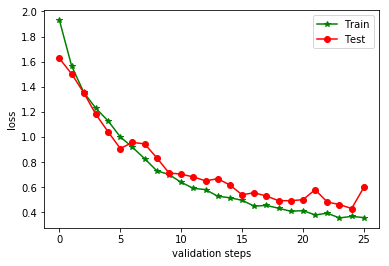

In [7]:


fig,ax = plt.subplots()
ax.plot(train_batch_loss,'g*',linestyle='solid',label='Train')
ax.plot(test_batch_loss,'ro',linestyle='solid',label='Test')
ax.set_ylabel('loss')
ax.set_xlabel('validation steps')
#ax.set_yscale('log')
ax.legend()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 



In [8]:

accuracy = 0
model.eval()
test_loss = 0
with torch.no_grad():
    step_test = 0
    for inputs, labels in testloader:
        step_test += 1

        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(testloader)} "
      f"Test accuracy: {accuracy/len(testloader)}")

Test loss: 0.46726986728137054 Test accuracy: 0.8441455696202531


## Saving your model
Using `torch.save`, save your model for future loading.

In [9]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'final_checkpoint.pth')